In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings('ignore')

import pickle
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

/Users/briand/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [19]:
def cond_join(c):
    if len(c[1])==0:
        return c[0]
    else:
        return '{}_{}'.format(c[0],c[1])
    
def entropy(p):
    return -1*(p*np.log(p) + (1-p)*np.log((1-p)))

#base_rate_entropy = entropy(train_df[y].mean())

def rel_row_entropy(row):
    e1 = entropy(row.HasDetections['mean'])
    return (base_rate_entropy - e1) / base_rate_entropy


#feature transformation functions

def clean_numeric(df, filler=None):
    #Clean missing values in numeric data
    df_numeric = df[x_numeric]

    if filler is None:
        medians = df_numeric.median()
    else:
        medians = filler
    
    df_numeric.fillna(medians, inplace=True)
    return df_numeric, medians

def get_booleans(df, y, x, rel_thresh=0.0001, n_thresh=500):
    '''
    Feature construction/selection:
    - compute entropy in each category. 
    - If relative entropy is above a threshold, convert to binary
    - check to make sure no more than K-1 features

    '''
    df_grp_x = df[[x,y]].groupby(x).agg([len, np.mean]).reset_index()
    df_grp_x['relent'] = df_grp_x.apply(rel_row_entropy, axis=1)
    df_grp_x.columns = [cond_join(c) for c in df_grp_x.columns.values]
    df_grp_x_filt = df_grp_x[(df_grp_x.relent>rel_thresh) & (df_grp_x.HasDetections_len>n_thresh)]
    n_cats = df_grp_x.shape[0]
    chosen = list(df_grp_x_filt[x].values)
    if n_cats == len(chosen):
        return chosen[:-1]
    else:
        return chosen
    
def get_booleans_all_x(df):
    lab = 'MachineIdentifier'
    str_trans = {}

    for x in x_str:
        if x != lab:
            bools = get_booleans(df, y, x)
            loc_dict = {}
            for i, b in enumerate(bools):
                loc_dict[i] = b        
            str_trans[x] = loc_dict
    return str_trans

def transform_strings(df, str_trans):
    #Now create the string matrix
    df_str = pd.DataFrame(index=df.index)
    
    
    for x in str_trans:
        if len(x) > 0:
            loc_dict = str_trans[x]
            for i in range(len(loc_dict)):
                df_str[x+'_{}'.format(i)] = 1*(df[x]==loc_dict[i])
    return df_str
        
#Training 
def build_train_data(train_file):
    train_df = pd.read_csv(train_dev)
    train_df.set_index('MachineIdentifier', inplace=True)
    str_trans_train = get_booleans_all_x(train_df)
    train_df_str = transform_strings(train_df, str_trans_train)
    train_df_num, fillna_train = clean_numeric(train_df)
    train_all_x = train_df_num.merge(train_df_str, how='inner', left_index=True, right_index=True)
    train_y = train_df[y]
    return train_all_x, train_y, str_trans_train, fillna_train
    
#Test
def build_test_data(test_file, fillna_train, str_trans_train):
    test_df = pd.read_csv(test_file)
    test_df.set_index('MachineIdentifier', inplace=True)
    test_df_str = transform_strings(test_df, str_trans_train)
    test_df_num, fillna_train = clean_numeric(test_df, fillna_train)
    test_all_x = test_df_num.merge(test_df_str, how='inner', left_index=True, right_index=True)
    return test_all_x

class BestModelPackage(object):
    
    def __init__(self, model, features, fillna_values, str_transforms):
        self.model = model
        self.features = features
        self.fillna_values = fillna_values
        self.str_transforms = str_transforms

In [88]:
datadir = '~/data/'

train_dev = datadir + 'train_rand.csv'
train = datadir + 'train.csv'
train_df = pd.read_csv(train_dev)
train_df.set_index('MachineIdentifier', inplace=True)
y = 'HasDetections'

#Organize columns into groups by type
x_numeric = list(train_df.describe().columns.values)
x_ident = [x for x in x_numeric if 'Identifier' in x] #Some numeric columns actually IDs
x_numeric = list(set(x_numeric) - set(x_ident)) #Keep only true numerics
x_str = list(set(train_df.columns.values) - set(x_numeric))
x_numeric.remove(y)


modfile = '/Users/briand/data/MSFT_Best_Model_ALL2.pickle'
datadir = '~/data/'


with open(modfile, 'rb') as r:
    best_mod = pickle.load(r)

test_all_x = build_test_data(datadir + 'test_rand.csv', 
                             best_mod.fillna_values, 
                             best_mod.str_transforms)[best_mod.features].sample(n=50000)

test_all_x['y'] = np.ones(test_all_x.shape[0])

train_all_x = build_test_data(datadir + 'train_rand.csv', 
                             best_mod.fillna_values, 
                             best_mod.str_transforms)[best_mod.features].sample(n=50000)

train_all_x['y'] = np.zeros(train_all_x.shape[0])

exp_df = pd.concat([train_all_x, test_all_x])

from sklearn.model_selection import train_test_split

train, test = train_test_split(exp_df, test_size=0.2)

test_all_x.shape, train_all_x.shape, exp_df.shape, train.shape, test.shape

((50000, 168), (50000, 168), (100000, 168), (80000, 168), (20000, 168))

In [89]:
fset=list(train.drop('y', axis=1).columns.values)
fset.remove('Census_InternalBatteryNumberOfCharges')
fset.remove('Census_SystemVolumeTotalCapacity')


#rf = RandomForestClassifier(n_estimators=50)
#rf.fit(train.drop('y', axis=1), train['y'])
#preds = rf.predict_proba(test.drop('y', axis=1))[:,1]
#auc_rf = roc_auc_score(test['y'], preds)

In [90]:
lr = None
lr = LogisticRegression(C=1000)
lr.fit(train[fset], train['y'])
preds = lr.predict_proba(test[fset])[:,1]
auc_lr = roc_auc_score(test['y'], preds)

auc_lr

0.9363882254577439

(array([4114., 2388.,  700.,  432.,  473.,  659.,  700.,  353.,   59.,
          71.]),
 array([0.00320068, 0.10205306, 0.20090544, 0.29975782, 0.39861019,
        0.49746257, 0.59631495, 0.69516732, 0.7940197 , 0.89287208,
        0.99172445]),
 <a list of 10 Patch objects>)

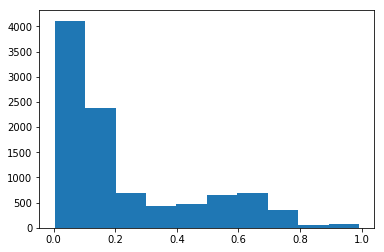

In [92]:
plt.hist(preds[(test['y']==0)])

Now score training set on P(Test). 
Keep only those where P(Test) > delta (0.2)

In [99]:
all_x = build_test_data(datadir + 'train.csv', 
                             best_mod.fillna_values, 
                             best_mod.str_transforms)[best_mod.features]

all_x.shape

(8921464, 167)

In [104]:
all_x['prob'] = lr.predict_proba(all_x[fset])[:,1]
all_x = all_x[(all_x.prob>0.4)]
all_x.shape

(2013008, 168)

In [105]:
all_x['prob'].to_csv(datadir + 'train_bias_weights.csv', sep=',', 
                    header=True, index=True, index_label='MachineIdentifier')

In [107]:
all_x = None

In [108]:
test_all_x = None
train_all_x = None 
exp_df = None 
train = None 
test = None

In [ ]:
def rel_row_entropy(row, base_rate_entropy):
    e1 = entropy(row.HasDetections['mean'])
    return (base_rate_entropy - e1) / base_rate_entropy



